# YOLO Models for Object Detection

YOLO (You Only Look Once) models are a family of object detection models known for their speed and accuracy. Unlike traditional object detection methods that use a sliding window approach, YOLO models frame object detection as a single regression problem, directly predicting bounding boxes and class probabilities from full images in one evaluation. This makes YOLO models extremely fast, making them suitable for real-time applications.

YOLO models consist of a single convolutional network that simultaneously predicts multiple bounding boxes and class probabilities for those boxes. The architecture is divided into several key components:

1. **Backbone**: This is typically a convolutional neural network (CNN) that extracts essential features from the input image.
2. **Neck**: This part of the network aggregates and combines features from different stages of the backbone. It often includes components like Feature Pyramid Networks (FPN) or Path Aggregation Networks (PAN).
3. **Head**: The final part of the network, which predicts the bounding boxes, objectness scores, and class probabilities. It usually consists of convolutional layers that output the final detection results.

YOLO models are quite easy to load and train because they provide pre-trained weights and a straightforward API for customization and fine-tuning.  The hardest part may be preparing the data in the format that the API expects.

In this notebook we'll show how to finetune a small YOLOv11 model (the latest as December, 2024) to detect pedestrians in the Penn-Fudan Pedestrian dataset.

We'll start with the usual imports and file paths:

In [1]:
from ultralytics import YOLO

# import local modules
from graphics_and_data_prep import display_yolo_predictions, prepare_penn_fudan_yolo, download_pennfudanped

from introdl.utils import config_paths_keys

config_paths_keys

MODELS_PATH=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/models')
DATA_PATH=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/data')
TORCH_HOME=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/downloads')


## Preparing Data for YOLO

Setting up a dataset for use with YOLO for object detection involves preparing images, labels, and a configuration file that YOLO requires for training. Here's a step-by-step guide:

---

### 1. **Dataset Structure**
Organize your dataset into a specific directory structure:
```
dataset/
├── images/
│   ├── train/
│   │   ├── image1.jpg
│   │   ├── image2.jpg
│   ├── val/
│   │   ├── image3.jpg
│   │   ├── image4.jpg
├── labels/
│   ├── train/
│   │   ├── image1.txt
│   │   ├── image2.txt
│   ├── val/
│   │   ├── image3.txt
│   │   ├── image4.txt
├── dataset.yaml
```

- **`images/`**: Contains images organized into `train` and `val` directories for training and validation.
- **`labels/`**: Contains label files corresponding to each image in the `images/` directory. The filenames must match the image filenames but with a `.txt` extension.

---

### 2. **Label Format**
Each `.txt` file should have one line per object in the image, with the following format:
```
class_id x_center y_center width height
```
- **`class_id`**: The index of the class (e.g., 0 for the first class).
- **`x_center`**, **`y_center`**, **`width`**, and **`height`**: The bounding box coordinates normalized to the image size (values between 0 and 1).
  - $x_{\text{center}} = \frac{x_{\text{min}} + x_{\text{max}}}{2 \cdot \text{image\_width}}$
  - $y_{\text{center}} = \frac{y_{\text{min}} + y_{\text{max}}}{2 \cdot \text{image\_height}}$
  - $\text{width} = \frac{x_{\text{max}} - x_{\text{min}}}{\text{image\_width}}$
  - $\text{height} = \frac{y_{\text{max}} - y_{\text{min}}}{\text{image\_height}}$

Example `.txt` file for an image with two objects:
```
0 0.5 0.5 0.2 0.2
1 0.7 0.3 0.1 0.1
```

---

### 3. **Dataset Configuration File (`dataset.yaml`)**
Create a YAML file to describe the dataset. This file is required by YOLO for training.

Example `dataset.yaml`:
```yaml
# Dataset paths
train: dataset/images/train/  # Path to training images
val: dataset/images/val/      # Path to validation images

# Number of classes
nc: 2  # Number of classes in the dataset

# Class names
names: ['class_0', 'class_1']
```

---

To do all of these step is a great use-case for an AI like ChatGPT.  We're using the Penn-Fudan Pedestrian dataset which is well known.  I wrote a prompt that went something like this:  "Write a function that accepts a dataset directory and processes the PennFudanPed dataset into a new dataset PenFudanPedYOLO that includes the images and ground truth boxes in YOLO format.  Download PennFudanPed if necessary. Split the data into training and validation sets with a seed for reproducibility.  Also write the dataset.yaml file in the new dataset directory."  The result, after a bit of tweaking, is the function `prepare_penn_fudan_yolo` that we import from the local module `graphics_and_data_prep.`  Feel free to open the file `graphics_and_data_prep.py` file in the same directory as this notebook to see the code.  You can also look in the created PennFudanPedYOLO directory to see how the data is structured.



In [3]:
# only need to run this once per platform, but it's safe to run multiple times
prepare_penn_fudan_yolo(DATA_PATH)

PennFudanPed dataset already exists.
Dataset preparation complete.


## Finetuning a YOLO model

YOLO saves multiple files, in addition to the model weights, during training and validation so we'll create a directory in MODELS_PATH to store those results.  We also need to tell YOLO where to find the dataset.yaml configuration file.

In [3]:

# Dataset and model save path
dataset_path = DATA_PATH / "PennFudanPedYOLO"
output_path = MODELS_PATH / "L06_yolov11"

# Create the output directory if it doesn't exist
output_path.mkdir(parents=True, exist_ok=True)

# dataset configuration file
data_config_file = dataset_path / "dataset.yaml"

Training the model is straight forward.  You may have to experiment with the number of epochs.  To learn more about the training options and different pretrained models that are available visit the [Ultralytics Website](https://docs.ultralytics.com/models/yolo11/).

In [4]:
# Load the YOLOv11 model (replace 'yolov11' with the exact pretrained weight name if available)
model = YOLO('yolo11s.pt')  # Pretrained YOLOv11 model

# Train the model
model.train(
    data=data_config_file,                # Path to the dataset configuration file
    epochs=30,                            # Adjust the number of epochs as needed
    imgsz=640,                            # Adjust the image size as needed
    project=output_path,                  # Save outputs in MODELS_PATH/yolov11
    name='PennFudan_experiment',          # Subdirectory for this experiment
    pretrained=True                       # Ensure pretrained weights are used
)

Ultralytics 8.3.39  Python-3.11.10 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
engine\trainer: task=detect, mode=train, model=yolo11s.pt, data=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\data\PennFudanPedYOLO\dataset.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\models\L06_yolov11, name=PennFudan_experiment, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=

train: Scanning C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\data\PennFudanPedYOLO\labels\train... 136 images, 0 backgrounds, 0 corrupt: 100%|██████████| 136/136 [00:00<00:00, 1088.29it/s]

train: New cache created: C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\data\PennFudanPedYOLO\labels\train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\data\PennFudanPedYOLO\labels\val... 34 images, 0 backgrounds, 0 corrupt: 100%|██████████| 34/34 [00:00<00:00, 665.64it/s]

val: New cache created: C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\data\PennFudanPedYOLO\labels\val.cache


Plotting labels to C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\models\L06_yolov11\PennFudan_experiment\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\models\L06_yolov11\PennFudan_experiment
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.28G     0.9936      3.663       1.22         52        640: 100%|██████████| 9/9 [00:02<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

                   all         34         91      0.799      0.857      0.818      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.34G     0.8984      1.603        1.1         56        640: 100%|██████████| 9/9 [00:00<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.44it/s]

                   all         34         91      0.896      0.857      0.891      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.37G      0.903      1.227       1.09         38        640: 100%|██████████| 9/9 [00:00<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.39it/s]

                   all         34         91      0.826      0.835        0.9      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.34G     0.9101     0.9415      1.087         45        640: 100%|██████████| 9/9 [00:00<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.43it/s]

                   all         34         91      0.889      0.793      0.877      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.38G     0.9656     0.9023      1.144         27        640: 100%|██████████| 9/9 [00:00<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.10it/s]

                   all         34         91      0.128       0.78      0.121     0.0633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.36G      1.059     0.9444      1.178         42        640: 100%|██████████| 9/9 [00:00<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.43it/s]

                   all         34         91      0.375      0.736      0.567      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.35G      1.158     0.9988      1.256         48        640: 100%|██████████| 9/9 [00:00<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.77it/s]

                   all         34         91      0.623      0.659      0.721      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.35G      1.034     0.9132      1.194         31        640: 100%|██████████| 9/9 [00:00<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.88it/s]

                   all         34         91     0.0449      0.582     0.0344     0.0183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.38G      1.012     0.8264      1.169         50        640: 100%|██████████| 9/9 [00:00<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.30it/s]

                   all         34         91     0.0409      0.484     0.0279     0.0143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.36G      1.028     0.8327      1.189         34        640: 100%|██████████| 9/9 [00:00<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.59it/s]

                   all         34         91      0.229      0.648      0.192        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.36G     0.9649     0.8185      1.139         42        640: 100%|██████████| 9/9 [00:00<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.17it/s]

                   all         34         91      0.549       0.56       0.42      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.38G      1.015     0.8012      1.189         33        640: 100%|██████████| 9/9 [00:00<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.55it/s]

                   all         34         91      0.842      0.764      0.825      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.35G     0.9468     0.7416       1.13         32        640: 100%|██████████| 9/9 [00:00<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.55it/s]

                   all         34         91      0.385      0.758      0.368      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.38G     0.9012     0.7404      1.095         39        640: 100%|██████████| 9/9 [00:00<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.73it/s]

                   all         34         91      0.633      0.791      0.786      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.38G     0.8827     0.7044       1.09         40        640: 100%|██████████| 9/9 [00:00<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.54it/s]

                   all         34         91      0.878      0.714      0.808      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      4.38G     0.9255     0.7082      1.115         37        640: 100%|██████████| 9/9 [00:00<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.77it/s]

                   all         34         91      0.875      0.747      0.822      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.33G     0.8734     0.6915      1.127         30        640: 100%|██████████| 9/9 [00:00<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.11it/s]

                   all         34         91      0.943      0.725      0.848      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      4.37G      0.839     0.6552      1.071         48        640: 100%|██████████| 9/9 [00:00<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.37it/s]

                   all         34         91      0.874      0.839      0.883      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      4.39G     0.8245     0.6331      1.066         44        640: 100%|██████████| 9/9 [00:00<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.03it/s]

                   all         34         91      0.802      0.868       0.88      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      4.36G     0.8118     0.6357      1.077         36        640: 100%|██████████| 9/9 [00:00<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.84it/s]

                   all         34         91      0.903      0.857       0.93      0.719


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      4.31G     0.6982     0.5856      1.006         15        640: 100%|██████████| 9/9 [00:01<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.98it/s]

                   all         34         91       0.78      0.824      0.748      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      4.36G     0.6854     0.5254      1.035         14        640: 100%|██████████| 9/9 [00:00<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.92it/s]

                   all         34         91      0.762      0.758      0.728      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.35G     0.6171     0.4933     0.9743         24        640: 100%|██████████| 9/9 [00:00<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.37it/s]

                   all         34         91      0.692       0.74      0.648      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      4.35G      0.623     0.4827     0.9833         21        640: 100%|██████████| 9/9 [00:00<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.90it/s]

                   all         34         91      0.841      0.879      0.852      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.31G     0.5787     0.4622     0.9752         22        640: 100%|██████████| 9/9 [00:00<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.53it/s]

                   all         34         91      0.953      0.895      0.949      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      4.36G     0.5722     0.4437     0.9574         18        640: 100%|██████████| 9/9 [00:00<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.48it/s]

                   all         34         91      0.899      0.945       0.95      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      4.35G     0.5337     0.3991     0.9289         20        640: 100%|██████████| 9/9 [00:00<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.65it/s]

                   all         34         91      0.894      0.945      0.951      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      4.35G     0.5435     0.4238     0.9395         22        640: 100%|██████████| 9/9 [00:00<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.40it/s]

                   all         34         91      0.906      0.951      0.953      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.32G     0.4909      0.396     0.9152         12        640: 100%|██████████| 9/9 [00:00<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.55it/s]

                   all         34         91      0.915      0.942      0.954      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      4.36G      0.475     0.3811      0.893         21        640: 100%|██████████| 9/9 [00:00<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.83it/s]

                   all         34         91      0.886      0.967      0.952      0.813



30 epochs completed in 0.019 hours.
Optimizer stripped from C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\models\L06_yolov11\PennFudan_experiment\weights\last.pt, 19.2MB
Optimizer stripped from C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\models\L06_yolov11\PennFudan_experiment\weights\best.pt, 19.2MB

Validating C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\models\L06_yolov11\PennFudan_experiment\weights\best.pt...
Ultralytics 8.3.39  Python-3.11.10 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.15it/s]


                   all         34         91      0.887      0.967      0.952      0.812
Speed: 0.0ms preprocess, 2.4ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\models\L06_yolov11\PennFudan_experiment


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000020CC5D72950>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

This validation step isn't strictly necessary, but if we look in the MODELS_PATH directory for the PennFudan_validation folder for the directory `PennFudan_validation` we'll see that several files are produced to help evaluate the model performance on the validation set.

In [5]:
# Validate the model
metrics = model.val(
    data=data_config_file,                # Path to the dataset configuration file
    project=output_path,                  # Save validation results in the same directory
    name='PennFudan_validation'           # Subdirectory for validation
)

# Display metrics
print("Validation Results:", metrics)

# Save the fine-tuned model weights
final_weights_path = output_path / "fine_tuned_yolov11.pt"
model.save(final_weights_path)

# Print completion message
print(f"Training and validation complete. Outputs saved to {output_path}")


Ultralytics 8.3.39  Python-3.11.10 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\data\PennFudanPedYOLO\labels\val.cache... 34 images, 0 backgrounds, 0 corrupt: 100%|██████████| 34/34 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


                   all         34         91       0.89      0.945      0.952       0.81
Speed: 0.3ms preprocess, 13.2ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\models\L06_yolov11\PennFudan_validation
Validation Results: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000020CEEE1F5D0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0

Finally, we've create a utility function to randomly sample some images from the validation set and plot both the prediction and ground truth boxes.

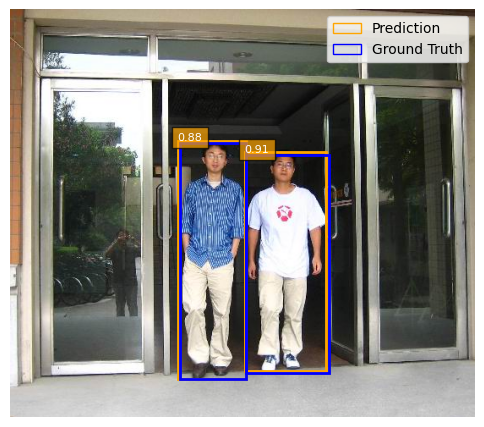

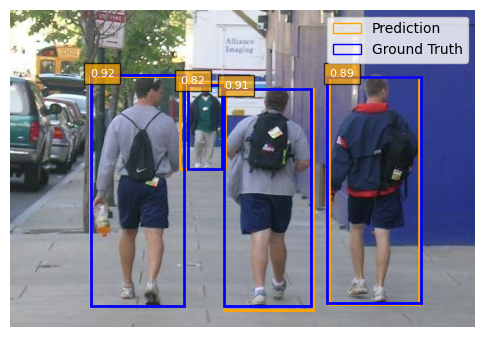

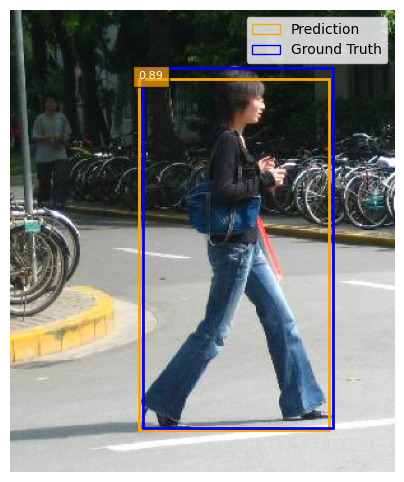

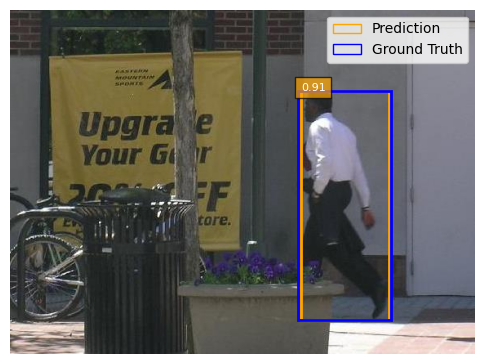

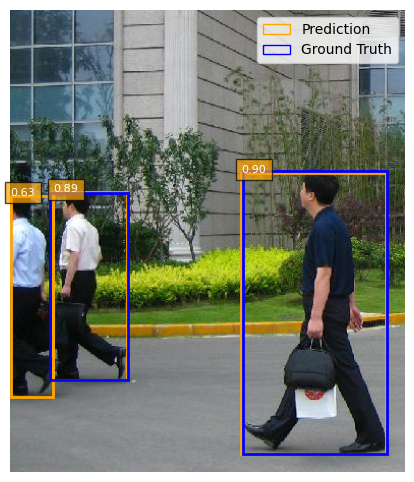

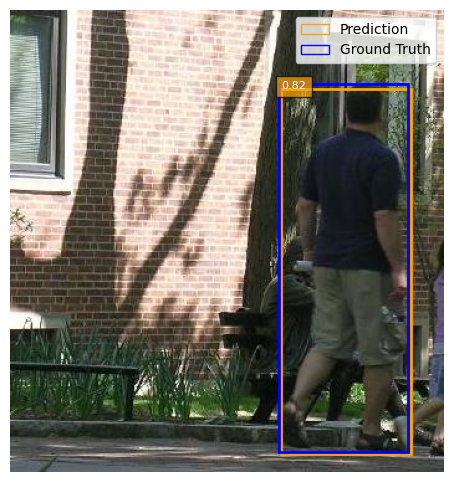

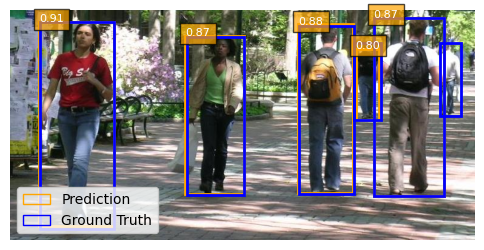

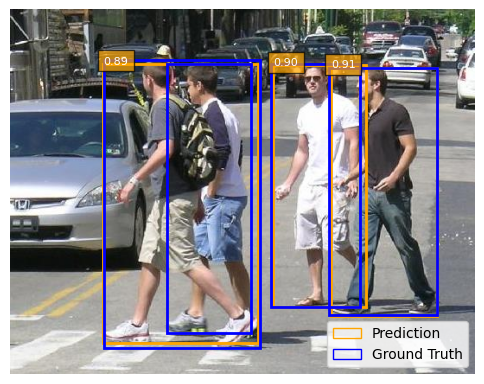

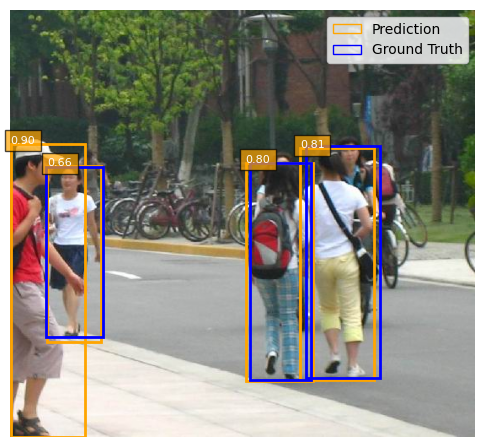

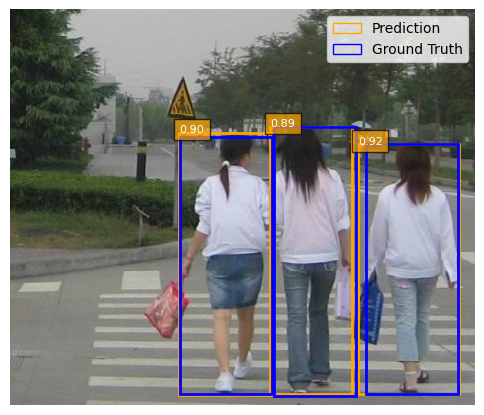

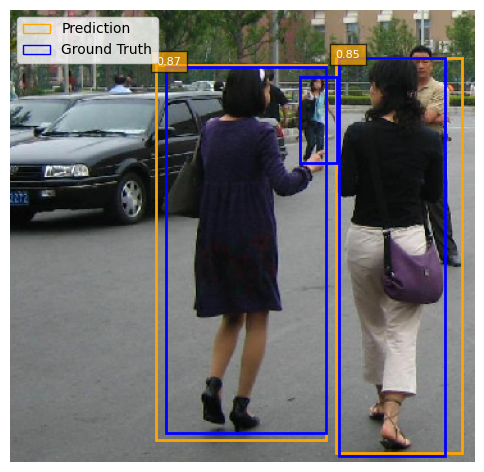

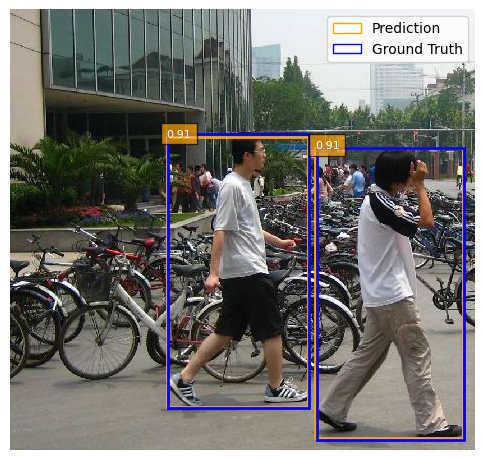

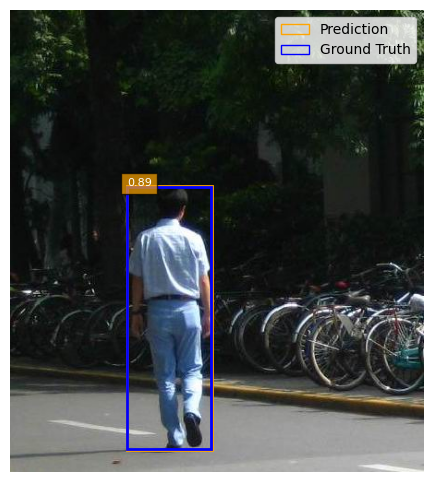

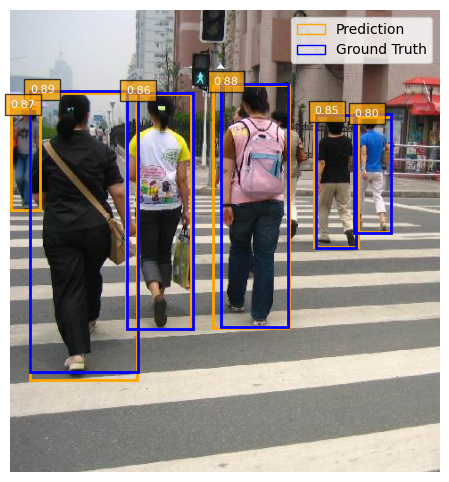

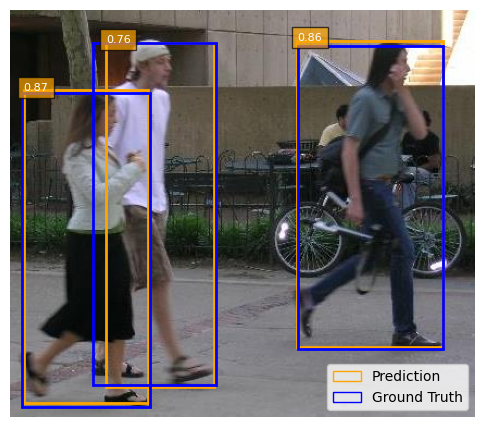

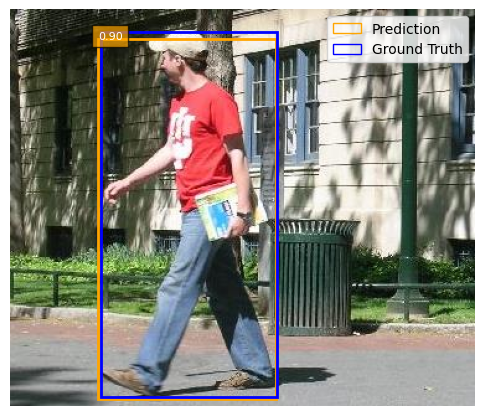

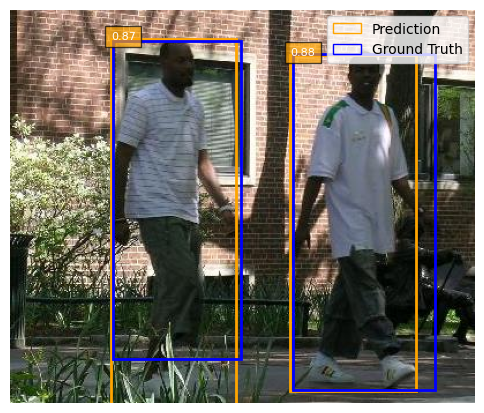

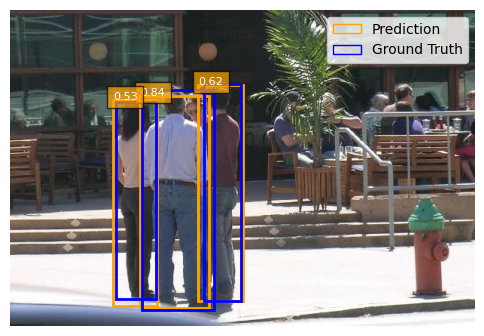

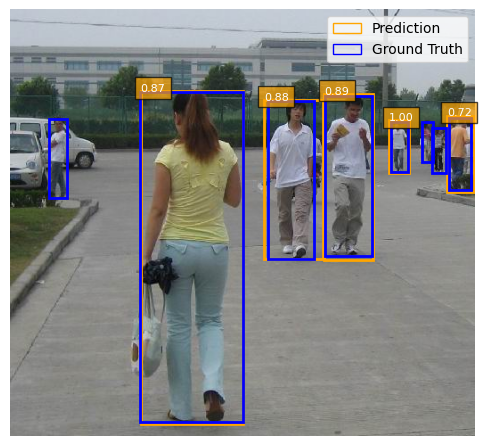

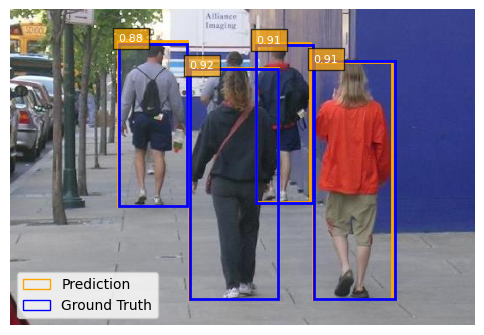

In [10]:
%matplotlib inline
# reload the model and display some randomly selected predictions
model = YOLO(final_weights_path)
display_yolo_predictions(data_config_file, model, num_samples=20, show_confidence=True, conf=0.5)